In [1]:
import numpy as np
from src.agent.utils import *
from src.agent.simulations import *
from src.agent.agent import RLAgent

import matplotlib.pyplot as plt
from matplotlib import colors
from tqdm import tqdm
from src.explorer.explorers import *

import pandas as pd
import seaborn as sns

In [2]:
x0 = 0
xF = 0
N_train = 300
N_test = 100
env = get_env()
train_Ppvs, train_Pconsos, test_Ppvs, test_Pconsos = get_train_test_sets(env, N_train=N_train, N_test=N_test)

In [3]:
S1_table = np.load('./data/experiments/bill_min/agent_001/PI-q-table.npy')

S1Agent = RLAgent(lr = lambda n : 1/n,
                    H = env.H,
                    nb_actions=41,
                    nb_states=101,
                    a_min=-20000,
                    a_max=20000,
                    delta_diff = 2,
                    delta_min = -50,
                    delta_max = 52,
                    nP=None,
                    save_agent=False,
                    dir_name=None,
                    optim_type='',
                    state_space='S1'
                    )

S2_table = np.load('./data/experiments/bill_min/agent_002/PI-q-table.npy')
S2Agent = RLAgent(lr = lambda n : 1/n,
                    H = env.H,
                    nb_actions=41,
                    nb_states=101,
                    a_min=-20000,
                    a_max=20000,
                    delta_diff = 2,
                    delta_min = -50,
                    delta_max = 52,
                    nP=None,
                    save_agent=False,
                    dir_name=None,
                    optim_type='',
                    state_space='S2'
                    )

S3_table = np.load('./data/experiments/bill_min/agent_003/PI-q-table.npy')
S3Agent = RLAgent(lr = lambda n : 1/n,
                    H = env.H,
                    nb_actions=41,
                    nb_states=101,
                    a_min=-20000,
                    a_max=20000,
                    delta_diff = 2,
                    delta_min = -50,
                    delta_max = 52,
                    nP=None,
                    save_agent=False,
                    dir_name=None,
                    optim_type='',
                    state_space='S3'
                    )

In [4]:
def collect_bills(x0=0):

    basic_Agent_bills = []
    sign_Agent_bills = []
    precise_Agent_bills = []
    precise_heuristic_Agent_bills = []
    idle_bills = []
    heuristic_bills = []



    for day in tqdm(range(N_test)):
        env.Ppv = test_Ppvs[day]
        env.Pconso = test_Pconsos[day]

        _, idle_traj, _ = simulation_idleAgent(env, S1Agent.H, x0=x0)
        _, heuristic_traj, _ = simulation_advanced_heuristic(env, S1Agent.H, x0=x0)
        _, basic_traj, _ = simulation_basicAgent(env, S1_table, S1Agent, x0=x0)
        _, sign_traj, sign_issues = simulation_signAgent(env, S2_table, S2Agent, x0=x0)
        _, precise_traj = simulation_preciseAgent(env, S3_table, S3Agent, x0=x0)
        _, agent_heuristic_traj_v2, _ = simulation_preciseAgent_with_heuristic(env, S3_table, S3Agent, x0=x0)

        idle_bills.append(idle_traj[:, 2].sum())
        heuristic_bills.append(heuristic_traj[:, 2].sum())
        basic_Agent_bills.append(basic_traj[:, 2].sum())
        sign_Agent_bills.append(sign_traj[:, 2].sum())
        precise_Agent_bills.append(precise_traj[:, 2].sum())
        precise_heuristic_Agent_bills.append(agent_heuristic_traj_v2[:, 2].sum())

    idle_bills = np.array(idle_bills)
    heuristic_bills = np.array(heuristic_bills)
    basic_Agent_bills = np.array(basic_Agent_bills)   
    sign_Agent_bills = np.array(sign_Agent_bills)
    precise_Agent_bills = np.array(precise_Agent_bills)
    precise_heuristic_Agent_bills = np.array(precise_heuristic_Agent_bills)
    
    return {'idle':idle_bills, 'heuristic':heuristic_bills, 'basic':basic_Agent_bills, 'sign':sign_Agent_bills, 'precise':precise_Agent_bills, 'precise+heuristic':precise_heuristic_Agent_bills}

In [5]:
def plot_fig(idle_bills, heuristic_bills, basic_Agent_bills, sign_Agent_bills, precise_Agent_bills, precise_heuristic_Agent_bills, save=False):

    ## combine these different collections into a list
    # data_to_plot = basic_Agent_bills.reshape(-1, 1) - np.stack((sign_Agent_bills, precise_Agent_bills, precise_heuristic_Agent_bills), axis=1)
    data_to_plot = idle_bills.reshape(-1, 1) - np.stack((heuristic_bills, basic_Agent_bills, sign_Agent_bills, precise_Agent_bills, precise_heuristic_Agent_bills), axis=1)

    medians = np.median(data_to_plot, axis=0)
    means = np.mean(data_to_plot, axis=0)
    quartile1 = np.quantile(data_to_plot, 0.25 , axis=0)
    quartile3 = np.quantile(data_to_plot, 0.75 , axis=0)
    inds = np.arange(len(medians))
    # labels = ["sign(cons-prod)", "discretized(cons-prod)", "discretized(cons-prod) + heuristic"]
    labels = ["Heuristic", r"$A_1$", "A2", "A3", "A4"]
    # Create a figure instance
    fig = plt.figure(figsize=(12, 8))

    # Create an axes instance
    ax = fig.add_axes([0.1,0.1,0.85,0.85]) # axis starts at 0.1, 0.1

    # Create the boxplot
    sns.boxplot(data=data_to_plot, boxprops={'facecolor':'None', 'alpha':1}, whis=np.infty)
    sns.swarmplot(data=data_to_plot, zorder=1, size=4.5)
    ax.grid()
    ax.set_xticks(np.arange(0, len(labels)), labels=labels)
    ax.set_xlabel("Agent", size=14)
    ax.set_ylabel("Bill reduction vs idle agent (no battery)", size=14)
    if save:
        plt.savefig("test.png")
    else:
        plt.show()
        
def plot_fig_from_df(dataframe, labels, save=False):
    legend_size = 14
    label_size = 20
    ## combine these different collections into a list
    inds = np.arange(len(labels))
    # Create a figure instance
    fig = plt.figure(figsize=(9, 6))

    # Create an axes instance
    ax = fig.add_axes([0.1,0.1,0.85,0.85]) # axis starts at 0.1, 0.1

    # Create the boxplot
    sns.boxplot(data=dataframe, boxprops={'facecolor':'None', 'alpha':1},y="bills", x="agent", whis=np.infty)
    sns.swarmplot(data=dataframe, zorder=1, size=4, y="bills", x="agent", hue="month")
    ax.grid()
    ax.set_xticks(np.arange(0, len(labels)), labels=labels, size=label_size)
    ax.set_xlabel("Agent", size=label_size)
    ax.set_ylabel("Bill reduction ($)", size=label_size)
    ax.tick_params(axis='both', which='major', labelsize=18)
    plt.setp(ax.get_legend().get_texts(), fontsize=legend_size) # for legend text
    plt.setp(ax.get_legend().get_title(), fontsize=legend_size) # for legend title
    
    if save:
        plt.savefig("cons_min.svg", format='svg')
    else:
        plt.show()


In [6]:
bills = collect_bills(x0=0)
idle_bills=bills["idle"]
heuristic_bills=bills["heuristic"]
basic_Agent_bills=bills["basic"]
sign_Agent_bills=bills["sign"]
precise_Agent_bills=bills["precise"]
precise_heuristic_Agent_bills = bills["precise+heuristic"]

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 97.63it/s]


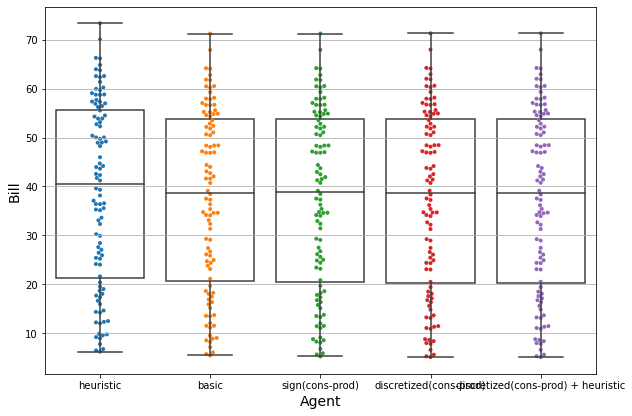

In [7]:
## combine these different collections into a list
# data_to_plot = basic_Agent_bills.reshape(-1, 1) - np.stack((sign_Agent_bills, precise_Agent_bills, precise_heuristic_Agent_bills), axis=1)
data_to_plot = np.stack((heuristic_bills, basic_Agent_bills, sign_Agent_bills, precise_Agent_bills, precise_heuristic_Agent_bills), axis=1)

medians = np.median(data_to_plot, axis=0)
means = np.mean(data_to_plot, axis=0)
quartile1 = np.quantile(data_to_plot, 0.25 , axis=0)
quartile3 = np.quantile(data_to_plot, 0.75 , axis=0)
inds = np.arange(len(medians))
# labels = ["sign(cons-prod)", "discretized(cons-prod)", "discretized(cons-prod) + heuristic"]
labels = ["heuristic", "basic", "sign(cons-prod)", "discretized(cons-prod)", "discretized(cons-prod) + heuristic"]
# Create a figure instance
fig = plt.figure(figsize=(9, 6))

# Create an axes instance
ax = fig.add_axes([0.1,0.1,0.85,0.85]) # axis starts at 0.1, 0.1
ax.grid()

# Create the boxplot
sns.boxplot(data=data_to_plot, boxprops={'facecolor':'None', 'alpha':1}, whis=np.infty)
sns.swarmplot(data=data_to_plot, zorder=1, size=4)
ax.set_xticks(np.arange(0, len(labels)), labels=labels)
ax.set_xlabel("Agent", size=14)
ax.set_ylabel("Bill", size=14)
plt.savefig("test.png")
# plt.show()


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 98.74it/s]


means: 39.62 38.63 37.29 37.24 37.18 37.17
medians: 41.27 40.41 38.77 38.80 38.74 38.76


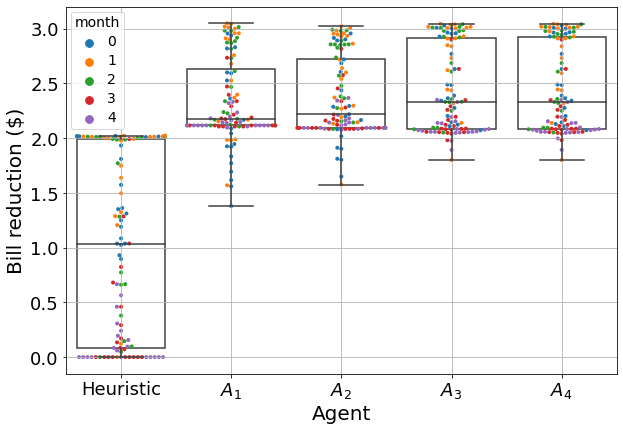

In [8]:
S1_table = np.load('./data/experiments/bill_min/agent_001/PI-q-table.npy')

S1Agent = RLAgent(lr = lambda n : 1/n,
                    H = env.H,
                    nb_actions=41,
                    nb_states=101,
                    a_min=-20000,
                    a_max=20000,
                    delta_diff = 2,
                    delta_min = -50,
                    delta_max = 52,
                    nP=None,
                    save_agent=False,
                    dir_name=None,
                    optim_type='',
                    state_space='S1'
                    )

S2_table = np.load('./data/experiments/bill_min/agent_002/PI-q-table.npy')
S2Agent = RLAgent(lr = lambda n : 1/n,
                    H = env.H,
                    nb_actions=41,
                    nb_states=101,
                    a_min=-20000,
                    a_max=20000,
                    delta_diff = 2,
                    delta_min = -50,
                    delta_max = 52,
                    nP=None,
                    save_agent=False,
                    dir_name=None,
                    optim_type='',
                    state_space='S2'
                    )

S3_table = np.load('./data/experiments/bill_min/agent_003/PI-q-table.npy')
S3Agent = RLAgent(lr = lambda n : 1/n,
                    H = env.H,
                    nb_actions=41,
                    nb_states=101,
                    a_min=-20000,
                    a_max=20000,
                    delta_diff = 2,
                    delta_min = -50,
                    delta_max = 52,
                    nP=None,
                    save_agent=False,
                    dir_name=None,
                    optim_type='',
                    state_space='S3'
                    )
x0 = 0

bills = collect_bills(x0=x0)
idle_bills=bills["idle"]
heuristic_bills = bills["heuristic"]
basic_Agent_bills=bills["basic"]
sign_Agent_bills=bills["sign"]
precise_Agent_bills=bills["precise"]
precise_heuristic_Agent_bills = bills["precise+heuristic"]

print('means:', 
      f'{idle_bills.mean():.2f}', 
      f'{heuristic_bills.mean():.2f}', 
      f'{basic_Agent_bills.mean():.2f}',
      f'{sign_Agent_bills.mean():.2f}',
      f'{precise_Agent_bills.mean():.2f}',
      f'{precise_heuristic_Agent_bills.mean():.2f}')
print('medians:', 
      f'{np.median(idle_bills):.2f}',
      f'{np.median(heuristic_bills):.2f}', 
      f'{np.median(basic_Agent_bills):.2f}', 
      f'{np.median(sign_Agent_bills):.2f}', 
      f'{np.median(precise_Agent_bills):.2f}',
      f'{np.median(precise_heuristic_Agent_bills):.2f}')

df = pd.DataFrame(np.concatenate(
                        (idle_bills - heuristic_bills,
                        idle_bills - basic_Agent_bills,
                        idle_bills - sign_Agent_bills,
                        idle_bills - precise_Agent_bills,
                        idle_bills - precise_heuristic_Agent_bills
                        ), axis=0))
df.rename(columns={0: "bills"}, inplace=True)
df['month'] = np.tile(np.repeat([0, 1, 2, 3, 4], 20), 5)
df['agent'] = np.repeat(['heuristic', 'basic', 'sign', 'precise', 'precise + heuristic'], 100)

plot_fig_from_df(df, labels=['Heuristic', r'$A_1$', r'$A_2$', r'$A_3$', r'$A_4$'], save=True)


# Experiment 2

## Monthly demand charges

In [9]:
S4_table = np.load('./data/experiments/peak_demand/agent_001/PI-q-table.npy')
S4Agent = RLAgent(lr = lambda n : 1/n,
                    H = env.H,
                    nb_actions=41,
                    nb_states=101,
                    a_min=-20000,
                    a_max=20000,
                    delta_diff = 2,
                    delta_min = -50,
                    delta_max = 52,
                    nP=93,
                    save_agent=False,
                    dir_name=None,
                    optim_type='',
                    state_space='S4'
                    )

S1_table = np.load('./data/experiments/bill_min/agent_001/PI-q-table.npy')

S1Agent = RLAgent(lr = lambda n : 1/n,
                    H = env.H,
                    nb_actions=41,
                    nb_states=101,
                    a_min=-20000,
                    a_max=20000,
                    delta_diff = 2,
                    delta_min = -50,
                    delta_max = 52,
                    nP=None,
                    save_agent=False,
                    dir_name=None,
                    optim_type='',
                    state_space='S1'
                    )

In [10]:
def get_bills_month(N_test, S4_table, S4Agent, S1Agent):
    test_set = np.arange(0, N_test).reshape(-1, 20)
    res_agent_cons = np.zeros(N_test).reshape(-1, 20)
    res_agent_dc = np.zeros(N_test).reshape(-1, 20)
    res_agent_heuristic_cons = np.zeros(N_test).reshape(-1, 20)
    res_agent_heuristic_dc = np.zeros(N_test).reshape(-1, 20)
    res_idle_cons = np.zeros(N_test).reshape(-1, 20)
    res_idle_dc = np.zeros(N_test).reshape(-1, 20)
    res_heuristic_cons = np.zeros(N_test).reshape(-1, 20)
    res_heuristic_dc = np.zeros(N_test).reshape(-1, 20)
    
    for m, month in enumerate(test_set):
        agent_heuristic_cons = []
        agent_cons = []
        idle_cons = []
        heuristic_cons = []
        agent_heuristic_dc = []
        agent_dc = []
        idle_dc = []
        heuristic_dc = []
        x0 = 0
        agent_heuristic_peak = 0
        agent_peak = 0
        idle_peak = 0
        heuristic_peak = 0
        
        for day in month:
            env.Ppv = test_Ppvs[day]
            env.Pconso = test_Pconsos[day]

            _, agent_heuristic_traj, new_peak = simulation_preciseAgent_with_heuristic_and_peak(env, S4_table, S4Agent, x0=x0, peak=agent_heuristic_peak, crit='month')
            agent_heuristic_peak = new_peak
            _, agent_traj, new_peak = simulation_preciseAgent_with_peak(env, S4_table, S4Agent, x0=x0, peak=agent_peak, crit='month')
            agent_peak = new_peak
            _, idle_traj, new_peak = simulation_idleAgent(env, S1Agent.H, x0=x0, peak=idle_peak, crit='month')
            idle_peak = new_peak
            _, heuristic_traj, new_peak = simulation_advanced_heuristic(env, S1Agent.H, x0=x0, peak=heuristic_peak, crit='month')
            heuristic_peak = new_peak
            
            agent_cons.append(agent_traj[:, 2].sum())
            agent_dc.append(agent_traj[:, 3].sum())
            agent_heuristic_cons.append(agent_heuristic_traj[:, 2].sum())
            agent_heuristic_dc.append(agent_heuristic_traj[:, 3].sum())
            idle_cons.append(idle_traj[:, 2].sum())
            idle_dc.append(idle_traj[:, 3].sum())
            heuristic_cons.append(heuristic_traj[:, 2].sum())
            heuristic_dc.append(heuristic_traj[:, 3].sum())
        
        for d, day in enumerate(month):
            res_agent_cons[m, d] = agent_cons[d]
            res_agent_dc[m, d] = np.max(agent_dc) / 20
            res_agent_heuristic_cons[m, d] = agent_heuristic_cons[d]
            res_agent_heuristic_dc[m, d] = np.max(agent_heuristic_dc) / 20
            res_heuristic_cons[m, d] = heuristic_cons[d]
            res_heuristic_dc[m, d] = np.max(heuristic_dc) / 20
            res_idle_cons[m, d] = idle_cons[d]
            res_idle_dc[m, d] = np.max(idle_dc) / 20
            
        
        
    return {'agent cons': res_agent_cons, 
            'agent peak': res_agent_dc,
            'agent heuristic cons': res_agent_heuristic_cons, 
            'agent heuristic peak': res_agent_heuristic_dc, 
            'heuristic cons': res_heuristic_cons, 
            'heuristic peak': res_heuristic_dc, 
            'idle cons': res_idle_cons, 
            'idle peak': res_idle_dc}       

In [11]:
res_dic = get_bills_month(100, S4_table, S4Agent, S1Agent)
agent_cons = res_dic['agent cons']
agent_peak = res_dic['agent peak']
agent_heuristic_cons = res_dic['agent heuristic cons']
agent_heuristic_peak = res_dic['agent heuristic peak']
heuristic_cons = res_dic['heuristic cons']
heuristic_peak = res_dic['heuristic peak']
idle_cons = res_dic['idle cons']
idle_peak = res_dic['idle peak']

In [12]:
df = pd.DataFrame(np.concatenate(((idle_cons + idle_peak).reshape(-1), 
                        (heuristic_cons + heuristic_peak).reshape(-1),
                        (agent_cons + agent_peak).reshape(-1),
                        (agent_heuristic_cons + agent_heuristic_peak).reshape(-1),), axis=0))
df.rename(columns={0: "bills"}, inplace=True)
df['month'] = np.tile(np.repeat([0, 1, 2, 3, 4], 20), 4)
df['agent'] = np.repeat(['idle', 'heuristic', 'agent', 'agent + heuristic'], 100)

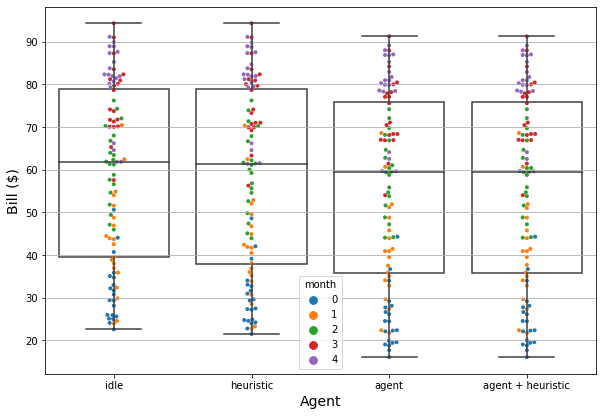

In [13]:
## combine these different collections into a list
data_to_plot = df

# labels = ["sign(cons-prod)", "discretized(cons-prod)", "discretized(cons-prod) + heuristic"]
labels = ["idle", "heuristic", "agent", "agent + heuristic"]
inds = np.arange(len(labels))
# Create a figure instance
fig = plt.figure(figsize=(9, 6))

# Create an axes instance
ax = fig.add_axes([0.1,0.1,0.85,0.85]) # axis starts at 0.1, 0.1
ax.grid()

# Create the boxplot
sns.boxplot(data=data_to_plot, boxprops={'facecolor':'None', 'alpha':1}, y="bills", x="agent", whis=np.infty)
sns.swarmplot(data=data_to_plot, zorder=1, size=4, y="bills", x="agent", hue="month")
ax.set_xticks(np.arange(0, len(labels)), labels=labels)
ax.set_xlabel("Agent", size=14)
ax.set_ylabel("Bill ($)", size=14)
plt.savefig("monthly_dc_bills.png")
# plt.show()


In [14]:
df2 = pd.DataFrame(np.concatenate(( 
                        (idle_cons + idle_peak).reshape(-1) - (heuristic_cons + heuristic_peak).reshape(-1),
                        (idle_cons + idle_peak).reshape(-1) - (agent_cons + agent_peak).reshape(-1),
                        (idle_cons + idle_peak).reshape(-1) - (agent_heuristic_cons + agent_heuristic_peak).reshape(-1),), axis=0))
df2.rename(columns={0: "bills"}, inplace=True)
df2['month'] = np.tile(np.repeat([0, 1, 2, 3, 4], 20), 3)
df2['agent'] = np.repeat(['heuristic', 'agent', 'agent + heuristic'], 100)

means: 58.61717133333334 57.63159913297595 55.32528633666666 55.32069658997319
medians: 61.87225 61.26804872374948 59.60022333333333 59.60022333333333
[16.51326167 26.71322833 43.706465   55.76263    55.39027167]
[15.  16.5 17.5 21.  25. ]
[31.51326167 43.21322833 61.206465   76.76263    80.39027167]
[14.48655212 24.02870803 41.38440476 53.6365695  53.56724854]
[10.5 16.5 17.5 20.  25. ]
[24.98655212 40.52870803 58.88440476 73.6365695  78.56724854]


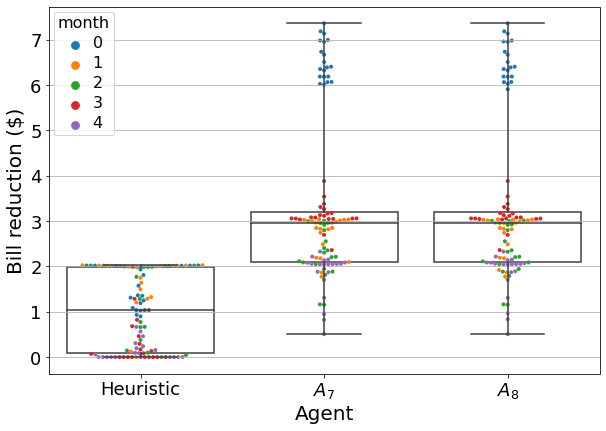

In [15]:
## combine these different collections into a list
data_to_plot = df2
legend_size = 16
label_size = 20

labels = ["Heuristic", r"$A_7$", r"$A_8$"]
inds = np.arange(len(labels))
# Create a figure instance
fig = plt.figure(figsize=(9, 6))

# Create an axes instance
ax = fig.add_axes([0.1,0.1,0.85,0.85]) # axis starts at 0.1, 0.1
ax.grid()

# Create the boxplot
sns.boxplot(data=data_to_plot, boxprops={'facecolor':'None', 'alpha':1},y="bills", x="agent", whis=np.infty)
sns.swarmplot(data=data_to_plot, zorder=1, size=4, y="bills", x="agent", hue="month")
ax.set_xticks(np.arange(0, len(labels)), labels=labels, fontsize=label_size)
ax.set_xlabel("Agent", size=label_size)
ax.set_ylabel("Bill reduction ($)", size=label_size)
plt.setp(ax.get_legend().get_texts(), fontsize=legend_size) # for legend text
plt.setp(ax.get_legend().get_title(), fontsize=legend_size) # for legend title
ax.tick_params(axis='both', which='major', labelsize=18)
plt.savefig("monthly_dc_improvement.svg", format='svg')
# plt.show()

print('means:', 
      np.mean((idle_cons + idle_peak).reshape(-1)), 
      np.mean((heuristic_cons + heuristic_peak).reshape(-1)),
      np.mean((agent_cons + agent_peak).reshape(-1)),
      np.mean((agent_heuristic_cons + agent_heuristic_peak).reshape(-1)))

print('medians:', 
      np.median((idle_cons + idle_peak).reshape(-1)), 
      np.median((heuristic_cons + heuristic_peak).reshape(-1)),
      np.median((agent_cons + agent_peak).reshape(-1)),
      np.median((agent_heuristic_cons + agent_heuristic_peak).reshape(-1)))

print(np.mean((idle_cons), axis=1))
print(np.mean((idle_peak), axis=1))
print(np.mean((idle_cons + idle_peak), axis=1))

print(np.mean((agent_heuristic_cons), axis=1))
print(np.mean((agent_heuristic_peak), axis=1))
print(np.mean((agent_heuristic_cons + agent_heuristic_peak), axis=1))

In [16]:
print('agent + heuristic')
print('bill reduction')
print(((idle_cons + idle_peak) - (agent_heuristic_cons + agent_heuristic_peak)).reshape(-1).mean())

print('energy reduction')
print(((idle_cons) - (agent_heuristic_cons)).reshape(-1).mean())

print('peak reduction')
print(((idle_peak) - (agent_heuristic_peak)).reshape(-1).mean())

print('------------')

print('agent')
print('bill reduction')
print(((idle_cons + idle_peak) - (agent_cons + agent_peak)).reshape(-1).mean())

print('energy reduction')
print(((idle_cons) - (agent_cons)).reshape(-1).mean())

print('peak reduction')
print(((idle_peak) - (agent_peak)).reshape(-1).mean())
print('------------')

print('Day with small reduction')
print('bill reduction')
print(((idle_cons + idle_peak) - (agent_heuristic_cons + agent_heuristic_peak))[4, 0])
print('energy reduction')
print(((idle_cons) - (agent_heuristic_cons))[4, 0])
print('peak reduction')
print(((idle_peak) - (agent_heuristic_peak))[4, 0])
print('------------')

print('Day with big reduction')
print('bill reduction')
print(((idle_cons + idle_peak) - (agent_heuristic_cons + agent_heuristic_peak))[0, 15])
print('energy reduction')
print(((idle_cons) - (agent_heuristic_cons))[0, 15])
print('peak reduction')
print(((idle_peak) - (agent_heuristic_peak))[0, 15])

agent + heuristic
bill reduction
3.2964747433601382
energy reduction
2.196474743360138
peak reduction
1.1
------------
agent
bill reduction
3.291884996666667
energy reduction
2.191884996666667
peak reduction
1.1
------------
Day with small reduction
bill reduction
0.968494133333337
energy reduction
0.968494133333337
peak reduction
0.0
------------
Day with big reduction
bill reduction
7.359000000000002
energy reduction
2.8590000000000018
peak reduction
4.5


In [17]:
print('agent + heuristic')
print('month 0')
print('bill reduction')
print(((idle_cons + idle_peak) - (agent_heuristic_cons + agent_heuristic_peak))[0].mean())

print('energy reduction')
print(((idle_cons) - (agent_heuristic_cons))[0].mean())

print('peak reduction')
print(((idle_peak) - (agent_heuristic_peak))[0].mean())
print('------------')
print('month 1')
print('bill reduction')
print(((idle_cons + idle_peak) - (agent_heuristic_cons + agent_heuristic_peak))[1].mean())

print('energy reduction')
print(((idle_cons) - (agent_heuristic_cons))[1].mean())

print('peak reduction')
print(((idle_peak) - (agent_heuristic_peak))[1].mean())
print('------------')
print('month 2')
print('bill reduction')
print(((idle_cons + idle_peak) - (agent_heuristic_cons + agent_heuristic_peak))[2].mean())

print('energy reduction')
print(((idle_cons) - (agent_heuristic_cons))[2].mean())

print('peak reduction')
print(((idle_peak) - (agent_heuristic_peak))[2].mean())
print('------------')
print('month 3')
print('bill reduction')
print(((idle_cons + idle_peak) - (agent_heuristic_cons + agent_heuristic_peak))[3].mean())

print('energy reduction')
print(((idle_cons) - (agent_heuristic_cons))[3].mean())

print('peak reduction')
print(((idle_peak) - (agent_heuristic_peak))[3].mean())
print('------------')
print('month 4')
print('bill reduction')
print(((idle_cons + idle_peak) - (agent_heuristic_cons + agent_heuristic_peak))[4].mean())

print('energy reduction')
print(((idle_cons) - (agent_heuristic_cons))[4].mean())

print('peak reduction')
print(((idle_peak) - (agent_heuristic_peak))[4].mean())

agent + heuristic
month 0
bill reduction
6.526709546666666
energy reduction
2.0267095466666656
peak reduction
4.5
------------
month 1
bill reduction
2.6845203066683703
energy reduction
2.684520306668369
peak reduction
0.0
------------
month 2
bill reduction
2.322060235934493
energy reduction
2.3220602359344924
peak reduction
0.0
------------
month 3
bill reduction
3.126060503333332
energy reduction
2.126060503333334
peak reduction
1.0
------------
month 4
bill reduction
1.8230231241978294
energy reduction
1.8230231241978299
peak reduction
0.0


previous peak: 0


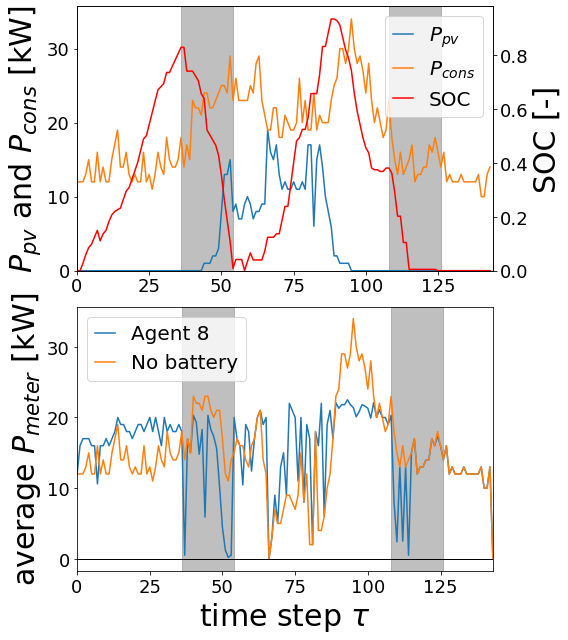

In [23]:
fig = plt.figure(figsize=(8, 9))
legend_size=20
label_size=30
    
month = 4
day = 0

idle_peak = 0
agent_peak = 0
for d in range(day):
    env.Ppv = test_Ppvs[20*month + d]
    env.Pconso = test_Pconsos[20*month+d]
    _, agent_heuristic_traj, new_agent_peak = simulation_preciseAgent_with_heuristic_and_peak(env, q_table, Agent, x0=x0, peak=agent_peak, crit='month')
    _, idle_traj, new_idle_peak = simulation_idleAgent(env, basicAgent.nb_times, x0=x0, peak=idle_peak, crit='month')
    idle_peak = new_idle_peak
    agent_peak = new_agent_peak
print('previous peak:', agent_peak)

env.Ppv = test_Ppvs[20*month + day]
env.Pconso = test_Pconsos[20*month+day]
_, agent_heuristic_traj, new_agent_peak = simulation_preciseAgent_with_heuristic_and_peak(env, S4_table, S4Agent, x0=x0, peak=agent_peak, crit='month')
_, idle_traj, new_idle_peak = simulation_idleAgent(env, S1Agent.H, x0=x0, peak=idle_peak, crit='month')

ax1 = fig.add_subplot(2,1,1)
lns1 = ax1.plot(env.Ppv, label=r'$P_{pv}$')
lns2 = ax1.plot(env.Pconso, label=r'$P_{cons}$')

ax1.axvspan(36, 54, alpha=0.5, color='gray')
ax1.axvspan(108, 126, alpha=0.5, color='gray')
ax1.set_ylabel(r'$P_{pv}$ and $P_{cons}$ [kW]', size=label_size)
ax2 = ax1.twinx()
lns3 = ax2.plot(agent_heuristic_traj[:, 0], color='red', label='SOC')
ax2.set_ylabel(r'SOC [-]', size=label_size)
ax2.tick_params(axis='y')
leg = lns1 + lns2 + lns3
labs = [l.get_label() for l in leg]
ax1.legend(leg, labs, loc='upper right', fontsize=legend_size, handlelength=1)
ax1.set_xlim(xmin=0, xmax=144)
ax1.tick_params(axis='both', which='major', labelsize=18)
ax2.tick_params(axis='both', which='major', labelsize=18)
ax1.set_ylim(ymin=0)
ax2.set_ylim(ymin=0)

ax3 = fig.add_subplot(2,1,2)
ax3.plot(agent_heuristic_traj[:144, 4]*6, label='Agent 8')
ax3.plot(idle_traj[:144, 4]*6, label='No battery')
ax3.axvspan(36, 54, alpha=0.5, color='gray')
ax3.axvspan(108, 126, alpha=0.5, color='gray')
ax3.hlines(y=0, xmin=0, xmax=143, color='k', linewidth=1)
ax3.set_ylabel(r'average $P_{meter}$ [kW]', size=label_size)
ax3.set_xlabel(r'time step $\tau$', size=label_size)
ax3.legend(fontsize=legend_size, handlelength=1)
ax3.set_xlim(xmin=0, xmax=143)
ax3.tick_params(axis='both', which='major', labelsize=18)
ax3.set_xlabel(r'time step $\tau$', size=label_size)

fig.tight_layout()
plt.savefig('bad_day_monthly_DC.svg', bbox_inches='tight', pad_inches = 0)



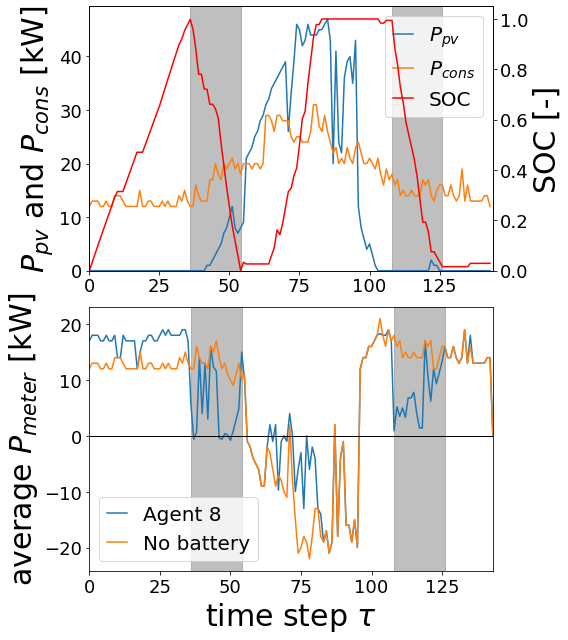

In [24]:
fig = plt.figure(figsize=(8, 9))
legend_size=20
label_size=30

month = 0
day = 15
idle_peak = 0
agent_peak = 0
for d in range(day):
    env.Ppv = test_Ppvs[20*month + d]
    env.Pconso = test_Pconsos[20*month+d]
    _, agent_heuristic_traj, new_agent_peak = simulation_preciseAgent_with_heuristic_and_peak(env, S4_table, S4Agent, x0=x0, peak=agent_peak, crit='month')
    _, idle_traj, new_idle_peak = simulation_idleAgent(env, S1Agent.H, x0=x0, peak=idle_peak, crit='month')
    idle_peak = new_idle_peak
    agent_peak = new_agent_peak

env.Ppv = test_Ppvs[20*month + day]
env.Pconso = test_Pconsos[20*month+day]
_, agent_heuristic_traj, new_agent_peak = simulation_preciseAgent_with_heuristic_and_peak(env, S4_table, S4Agent, x0=x0, peak=agent_peak, crit='month')
_, idle_traj, new_idle_peak = simulation_idleAgent(env, S1Agent.H, x0=x0, peak=idle_peak, crit='month')


ax4 = fig.add_subplot(2,1,1)
lns1 = ax4.plot(env.Ppv, label=r'$P_{pv}$')
lns2 = ax4.plot(env.Pconso, label=r'$P_{cons}$')

ax4.axvspan(36, 54, alpha=0.5, color='gray')
ax4.axvspan(108, 126, alpha=0.5, color='gray')
ax4.set_ylabel(r'$P_{pv}$ and $P_{cons}$ [kW]', size=label_size)
ax5 = ax4.twinx()
lns3 = ax5.plot(agent_heuristic_traj[:, 0], color='red', label='SOC')
ax5.set_ylabel(r'SOC [-]', size=label_size)
ax5.tick_params(axis='y')
leg = lns1 + lns2 + lns3
labs = [l.get_label() for l in leg]
ax4.legend(leg, labs, loc='upper right', fontsize=legend_size, handlelength=1)
ax4.set_xlim(xmin=0, xmax=144)
ax4.tick_params(axis='both', which='major', labelsize=18)
ax5.tick_params(axis='both', which='major', labelsize=18)
ax4.set_ylim(ymin=0)
ax5.set_ylim(ymin=0)

ax6 = fig.add_subplot(2,1,2)
ax6.plot(agent_heuristic_traj[:144, 4]*6, label='Agent 8')
ax6.plot(idle_traj[:144, 4]*6, label='No battery')
ax6.axvspan(36, 54, alpha=0.5, color='gray')
ax6.axvspan(108, 126, alpha=0.5, color='gray')
ax6.hlines(y=0, xmin=0, xmax=143, color='k', linewidth=1)
ax6.set_ylabel(r'average $P_{meter}$ [kW]', size=label_size)
ax6.set_xlabel(r'time step $\tau$', size=label_size)
ax6.legend(fontsize=legend_size, handlelength=1)
ax6.set_xlim(xmin=0, xmax=143)
ax6.tick_params(axis='both', which='major', labelsize=18)
ax6.set_xlabel(r'time step $\tau$', size=label_size)

fig.tight_layout()
plt.savefig('good_day_monthly_DC.svg', bbox_inches='tight', pad_inches = 0)

## Daily demand charges

In [28]:
S4_table = np.load('./data/experiments/peak_demand/agent_002/PI-q-table.npy')
S4Agent = RLAgent(lr = lambda n : 1/n,
                    H = env.H,
                    nb_actions=41,
                    nb_states=101,
                    a_min=-20000,
                    a_max=20000,
                    delta_diff = 2,
                    delta_min = -50,
                    delta_max = 52,
                    nP=93,
                    save_agent=False,
                    dir_name=None,
                    optim_type='',
                    state_space='S4'
                    )

S1_table = np.load('./data/experiments/bill_min/agent_001/PI-q-table.npy')

S1Agent = RLAgent(lr = lambda n : 1/n,
                    H = env.H,
                    nb_actions=41,
                    nb_states=101,
                    a_min=-20000,
                    a_max=20000,
                    delta_diff = 2,
                    delta_min = -50,
                    delta_max = 52,
                    nP=None,
                    save_agent=False,
                    dir_name=None,
                    optim_type='',
                    state_space='S1'
                    )

In [29]:
def get_bills_day(N_test, S4_table, S4Agent, S1Agent):
    test_set = np.arange(0, N_test).reshape(-1, 20)
    res_agent_cons = np.zeros(N_test).reshape(-1, 20)
    res_agent_dc = np.zeros(N_test).reshape(-1, 20)
    res_agent_heuristic_cons = np.zeros(N_test).reshape(-1, 20)
    res_agent_heuristic_dc = np.zeros(N_test).reshape(-1, 20)
    res_idle_cons = np.zeros(N_test).reshape(-1, 20)
    res_idle_dc = np.zeros(N_test).reshape(-1, 20)
    res_heuristic_cons = np.zeros(N_test).reshape(-1, 20)
    res_heuristic_dc = np.zeros(N_test).reshape(-1, 20)
    
    for m, month in enumerate(test_set):
        agent_heuristic_cons = []
        agent_cons = []
        idle_cons = []
        heuristic_cons = []
        agent_heuristic_dc = []
        agent_dc = []
        idle_dc = []
        heuristic_dc = []
        x0 = 0
        peak = 0
        
        for d, day in enumerate(month):
            env.Ppv = test_Ppvs[day]
            env.Pconso = test_Pconsos[day]

            _, agent_heuristic_traj, new_peak = simulation_preciseAgent_with_heuristic_and_peak(env, S4_table, S4Agent, x0=x0, peak=peak, crit='day')
            _, agent_traj, new_peak = simulation_preciseAgent_with_peak(env, S4_table, S4Agent, x0=x0, peak=peak, crit='day')
            _, idle_traj, new_peak = simulation_idleAgent(env, S1Agent.H, x0=x0, peak=peak, crit='day')
            _, heuristic_traj, new_peak = simulation_advanced_heuristic(env, S1Agent.H, x0=x0, peak=peak, crit='day')
            
            res_agent_cons[m, d] = agent_traj[:, 2].sum()
            res_agent_dc[m, d] = agent_traj[:, 3].sum()
            res_agent_heuristic_cons[m, d] = agent_heuristic_traj[:, 2].sum()
            res_agent_heuristic_dc[m, d] = agent_heuristic_traj[:, 3].sum()
            res_idle_cons[m, d] = idle_traj[:, 2].sum()
            res_heuristic_dc[m, d] = idle_traj[:, 3].sum()
            res_heuristic_cons[m, d] = heuristic_traj[:, 2].sum()
            res_idle_dc[m, d] = heuristic_traj[:, 3].sum()   
        
        
    return {'agent cons': res_agent_cons, 
            'agent peak': res_agent_dc,
            'agent heuristic cons': res_agent_heuristic_cons, 
            'agent heuristic peak': res_agent_heuristic_dc, 
            'heuristic cons': res_heuristic_cons, 
            'heuristic peak': res_heuristic_dc, 
            'idle cons': res_idle_cons, 
            'idle peak': res_idle_dc}       

In [30]:
res_dic = get_bills_day(100, S4_table, S4Agent, S1Agent)
agent_cons = res_dic['agent cons']
agent_peak = res_dic['agent peak']
agent_heuristic_cons = res_dic['agent heuristic cons']
agent_heuristic_peak = res_dic['agent heuristic peak']
heuristic_cons = res_dic['heuristic cons']
heuristic_peak = res_dic['heuristic peak']
idle_cons = res_dic['idle cons']
idle_peak = res_dic['idle peak']

In [31]:
df = pd.DataFrame(np.concatenate(((idle_cons + idle_peak).reshape(-1), 
                        (heuristic_cons + heuristic_peak).reshape(-1),
                        (agent_cons + agent_peak).reshape(-1),
                        (agent_heuristic_cons + agent_heuristic_peak).reshape(-1),), axis=0))
df.rename(columns={0: "bills"}, inplace=True)
df['month'] = np.tile(np.repeat([0, 1, 2, 3, 4], 20), 4)
df['agent'] = np.repeat(['idle', 'heuristic', 'agent', 'agent + heuristic'], 100)

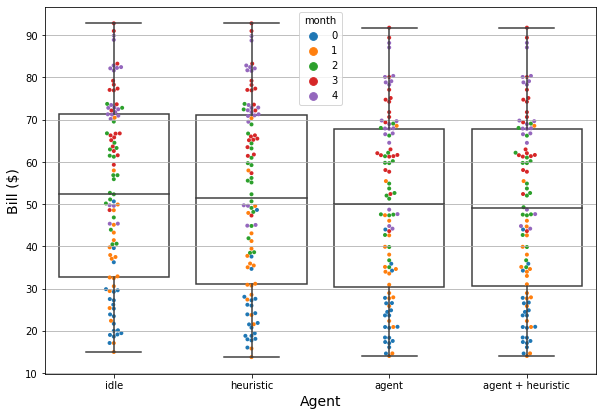

In [32]:
## combine these different collections into a list
data_to_plot = df

labels = ["idle", "heuristic", "agent", "agent + heuristic"]
inds = np.arange(len(labels))
# Create a figure instance
fig = plt.figure(figsize=(9, 6))

# Create an axes instance
ax = fig.add_axes([0.1,0.1,0.85,0.85]) # axis starts at 0.1, 0.1
ax.grid()

# Create the boxplot
sns.boxplot(data=data_to_plot, boxprops={'facecolor':'None', 'alpha':1}, y="bills", x="agent", whis=np.infty)
sns.swarmplot(data=data_to_plot, zorder=1, size=4, y="bills", x="agent", hue="month")
ax.set_xticks(np.arange(0, len(labels)), labels=labels)
ax.set_xlabel("Agent", size=14)
ax.set_ylabel("Bill ($)", size=14)
# plt.savefig("daily_dc_bills.png")
# plt.show()


In [33]:
df2 = pd.DataFrame(np.concatenate(( 
                        (idle_cons + idle_peak).reshape(-1) - (heuristic_cons + heuristic_peak).reshape(-1),
                        (idle_cons + idle_peak).reshape(-1) - (agent_cons + agent_peak).reshape(-1),
                        (idle_cons + idle_peak).reshape(-1) - (agent_heuristic_cons + agent_heuristic_peak).reshape(-1),), axis=0))
df2.rename(columns={0: "bills"}, inplace=True)
df2['month'] = np.tile(np.repeat([0, 1, 2, 3, 4], 20), 3)
df2['agent'] = np.repeat(['heuristic', 'agent', 'agent + heuristic'], 100)

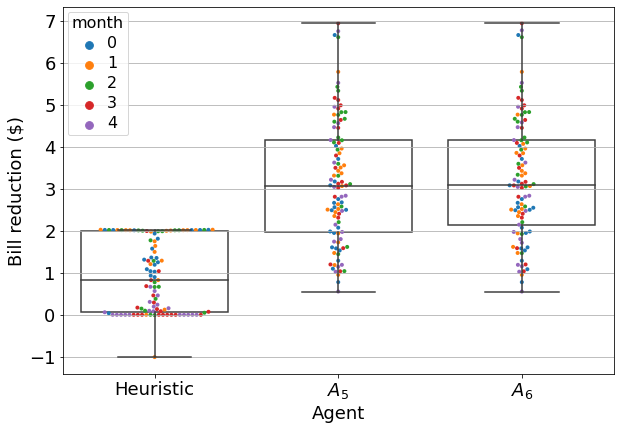

In [34]:
## combine these different collections into a list
data_to_plot = df2
legend_size = 16
label_size = 18

labels = ["Heuristic", r"$A_5$", r"$A_6$"]
inds = np.arange(len(labels))
# Create a figure instance
fig = plt.figure(figsize=(9, 6))

# Create an axes instance
ax = fig.add_axes([0.1,0.1,0.85,0.85]) # axis starts at 0.1, 0.1
ax.grid()

# Create the boxplot
sns.boxplot(data=data_to_plot, boxprops={'facecolor':'None', 'alpha':1},y="bills", x="agent", whis=np.infty)
sns.swarmplot(data=data_to_plot, zorder=1, size=4, y="bills", x="agent", hue="month")
ax.set_xticks(np.arange(0, len(labels)), labels=labels, fontsize=label_size)
ax.set_xlabel("Agent", size=label_size)
ax.set_ylabel("Bill reduction ($)", size=label_size)
plt.setp(ax.get_legend().get_texts(), fontsize=legend_size) # for legend text
plt.setp(ax.get_legend().get_title(), fontsize=legend_size) # for legend title
ax.tick_params(axis='both', which='major', labelsize=18)
# plt.savefig("daily_dc_improvement.svg", format='svg')

In [35]:
print('agent + heuristic')
print('bill reduction')
print(((idle_cons + idle_peak) - (agent_heuristic_cons + agent_heuristic_peak)).reshape(-1).mean())

print('energy reduction')
print(((idle_cons) - (agent_heuristic_cons)).reshape(-1).mean())

print('peak reduction')
print(((idle_peak) - (agent_heuristic_peak)).reshape(-1).mean())

print('------------')

print('agent')
print('bill reduction')
print(((idle_cons + idle_peak) - (agent_cons + agent_peak)).reshape(-1).mean())

print('energy reduction')
print(((idle_cons) - (agent_cons)).reshape(-1).mean())

print('peak reduction')
print(((idle_peak) - (agent_peak)).reshape(-1).mean())
print('------------')

print('Day with small reduction')
print('bill reduction')
print(((idle_cons + idle_peak) - (agent_heuristic_cons + agent_heuristic_peak))[0, 4])
print('energy reduction')
print(((idle_cons) - (agent_heuristic_cons))[0, 4])
print('peak reduction')
print(((idle_peak) - (agent_heuristic_peak))[0, 4])
print('------------')

print('Day with big reduction')
print('bill reduction')
print(((idle_cons + idle_peak) - (agent_heuristic_cons + agent_heuristic_peak))[0, 16])
print('energy reduction')
print(((idle_cons) - (agent_heuristic_cons))[0, 16])
print('peak reduction')
print(((idle_peak) - (agent_heuristic_peak))[0, 16])

agent + heuristic
bill reduction
3.2127718484204832
energy reduction
1.9527718484204837
peak reduction
1.26
------------
agent
bill reduction
3.159023942333333
energy reduction
1.9490239423333338
peak reduction
1.21
------------
Day with small reduction
bill reduction
0.7766300000000008
energy reduction
1.776629999999999
peak reduction
-1.0
------------
Day with big reduction
bill reduction
6.655081066666668
energy reduction
2.6550810666666678
peak reduction
4.0


In [36]:
print('agent + heuristic')
print('month 0')
print('bill reduction')
print(((idle_cons + idle_peak) - (agent_heuristic_cons + agent_heuristic_peak))[0].mean())

print('energy reduction')
print(((idle_cons) - (agent_heuristic_cons))[0].mean())

print('peak reduction')
print(((idle_peak) - (agent_heuristic_peak))[0].mean())
print('------------')
print('month 1')
print('bill reduction')
print(((idle_cons + idle_peak) - (agent_heuristic_cons + agent_heuristic_peak))[1].mean())

print('energy reduction')
print(((idle_cons) - (agent_heuristic_cons))[1].mean())

print('peak reduction')
print(((idle_peak) - (agent_heuristic_peak))[1].mean())
print('------------')
print('month 2')
print('bill reduction')
print(((idle_cons + idle_peak) - (agent_heuristic_cons + agent_heuristic_peak))[2].mean())

print('energy reduction')
print(((idle_cons) - (agent_heuristic_cons))[2].mean())

print('peak reduction')
print(((idle_peak) - (agent_heuristic_peak))[2].mean())
print('------------')
print('month 3')
print('bill reduction')
print(((idle_cons + idle_peak) - (agent_heuristic_cons + agent_heuristic_peak))[3].mean())

print('energy reduction')
print(((idle_cons) - (agent_heuristic_cons))[3].mean())

print('peak reduction')
print(((idle_peak) - (agent_heuristic_peak))[3].mean())
print('------------')
print('month 4')
print('bill reduction')
print(((idle_cons + idle_peak) - (agent_heuristic_cons + agent_heuristic_peak))[4].mean())

print('energy reduction')
print(((idle_cons) - (agent_heuristic_cons))[4].mean())

print('peak reduction')
print(((idle_peak) - (agent_heuristic_peak))[4].mean())

agent + heuristic
month 0
bill reduction
2.499850471666666
energy reduction
2.199850471666666
peak reduction
0.3
------------
month 1
bill reduction
3.069406786380408
energy reduction
2.4694067863804086
peak reduction
0.6
------------
month 2
bill reduction
3.9330115468243583
energy reduction
1.9830115468243588
peak reduction
1.95
------------
month 3
bill reduction
3.563206823333336
energy reduction
1.5882068233333353
peak reduction
1.975
------------
month 4
bill reduction
2.998383613897651
energy reduction
1.5233836138976506
peak reduction
1.475


# Peaks comparison

In [49]:
S4_table = np.load('./data/experiments/peak_demand/agent_001/PI-q-table.npy')
S4Agent = RLAgent(lr = lambda n : 1/n,
                    H = env.H,
                    nb_actions=41,
                    nb_states=101,
                    a_min=-20000,
                    a_max=20000,
                    delta_diff = 2,
                    delta_min = -50,
                    delta_max = 52,
                    nP=93,
                    save_agent=False,
                    dir_name=None,
                    optim_type='',
                    state_space='S4'
                    )

S1_table = np.load('./data/experiments/bill_min/agent_001/PI-q-table.npy')

S1Agent = RLAgent(lr = lambda n : 1/n,
                    H = env.H,
                    nb_actions=41,
                    nb_states=101,
                    a_min=-20000,
                    a_max=20000,
                    delta_diff = 2,
                    delta_min = -50,
                    delta_max = 52,
                    nP=None,
                    save_agent=False,
                    dir_name=None,
                    optim_type='',
                    state_space='S1'
                    )

In [50]:
def get_peaks_month(N_test, S4_table, S4Agent, S1Agent):
    test_set = np.arange(0, N_test).reshape(-1, 20)
    agent_heuristic_dc = []
    agent_dc = []
    idle_dc = []
    heuristic_dc = []
    
    for m, month in enumerate(test_set):
        x0 = 0
        agent_heuristic_peak = 0
        agent_peak = 0
        idle_peak = 0
        heuristic_peak = 0
        
        for day in month:
            env.Ppv = test_Ppvs[day]
            env.Pconso = test_Pconsos[day]

            _, agent_heuristic_traj, new_peak = simulation_preciseAgent_with_heuristic_and_peak(env, S4_table, S4Agent, x0=x0, peak=agent_heuristic_peak, crit='month')
            agent_heuristic_peak = new_peak
            _, agent_traj, new_peak = simulation_preciseAgent_with_peak(env, S4_table, S4Agent, x0=x0, peak=agent_peak, crit='month')
            agent_peak = new_peak
            _, idle_traj, new_peak = simulation_idleAgent(env, S1Agent.H, x0=x0, peak=idle_peak, crit='month')
            idle_peak = new_peak
            _, heuristic_traj, new_peak = simulation_advanced_heuristic(env, S1Agent.H, x0=x0, peak=heuristic_peak, crit='month')
            heuristic_peak = new_peak
            
            agent_dc.append(agent_traj[:-1, 4])
            agent_heuristic_dc.append(agent_heuristic_traj[:-1, 4])
            idle_dc.append(idle_traj[:-1, 4])
            heuristic_dc.append(heuristic_traj[:-1, 4])
            
        
        
    return {'agent Pmeters': agent_dc,
            'agent heuristic Pmeters': agent_heuristic_dc, 
            'heuristic Pmeters': heuristic_dc, 
            'idle Pmeters': idle_dc}       

In [51]:
res_dic = get_peaks_month(100, S4_table, S4Agent, S1Agent)
agent_Pmeters = res_dic['agent Pmeters']
agent_heuristic_Pmeters = res_dic['agent heuristic Pmeters']
heuristic_Pmeters = res_dic['heuristic Pmeters']
idle_Pmeters = res_dic['idle Pmeters']

In [52]:
S4_table = np.load('./data/experiments/peak_demand/agent_002/PI-q-table.npy')
S4Agent = RLAgent(lr = lambda n : 1/n,
                    H = env.H,
                    nb_actions=41,
                    nb_states=101,
                    a_min=-20000,
                    a_max=20000,
                    delta_diff = 2,
                    delta_min = -50,
                    delta_max = 52,
                    nP=93,
                    save_agent=False,
                    dir_name=None,
                    optim_type='',
                    state_space='S4'
                    )

S1_table = np.load('./data/experiments/bill_min/agent_001/PI-q-table.npy')

S1Agent = RLAgent(lr = lambda n : 1/n,
                    H = env.H,
                    nb_actions=41,
                    nb_states=101,
                    a_min=-20000,
                    a_max=20000,
                    delta_diff = 2,
                    delta_min = -50,
                    delta_max = 52,
                    nP=None,
                    save_agent=False,
                    dir_name=None,
                    optim_type='',
                    state_space='S1'
                    )

In [53]:
def get_peaks_day(N_test, S4_table, S4Agent, S1Agent):
    test_set = np.arange(0, N_test).reshape(-1, 20)
    agent_heuristic_dc = []
    agent_dc = []
    idle_dc = []
    heuristic_dc = []
    
    for m, month in enumerate(test_set):
        x0 = 0
        peak = 0
        
        for day in month:
            env.Ppv = test_Ppvs[day]
            env.Pconso = test_Pconsos[day]

            _, agent_heuristic_traj, new_peak = simulation_preciseAgent_with_heuristic_and_peak(env, S4_table, S4Agent, x0=x0, peak=peak, crit='day')
            agent_heuristic_peak = new_peak
            _, agent_traj, new_peak = simulation_preciseAgent_with_peak(env, S4_table, S4Agent, x0=x0, peak=peak, crit='day')
            agent_peak = new_peak
            _, idle_traj, new_peak = simulation_idleAgent(env, S1Agent.H, x0=x0, peak=peak, crit='day')
            idle_peak = new_peak
            _, heuristic_traj, new_peak = simulation_advanced_heuristic(env, S1Agent.H, x0=x0, peak=peak, crit='day')
            heuristic_peak = new_peak
            
            agent_dc.append(agent_traj[:-1, 4])
            agent_heuristic_dc.append(agent_heuristic_traj[:-1, 4])
            idle_dc.append(idle_traj[:-1, 4])
            heuristic_dc.append(heuristic_traj[:-1, 4])
            
        
        
    return {'agent Pmeters': agent_dc,
            'agent heuristic Pmeters': agent_heuristic_dc, 
            'heuristic Pmeters': heuristic_dc, 
            'idle Pmeters': idle_dc}       

In [54]:
res2_dic = get_peaks_day(100, S4_table, S4Agent, S1Agent)
agent2_Pmeters = res2_dic['agent Pmeters']
agent2_heuristic_Pmeters = res2_dic['agent heuristic Pmeters']
heuristic2_Pmeters = res2_dic['heuristic Pmeters']
idle2_Pmeters = res2_dic['idle Pmeters']

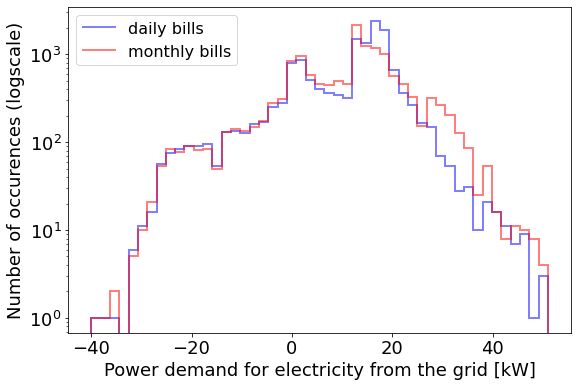

In [59]:
fig, ax = plt.subplots(figsize=(9,6))
bins = np.linspace(-40, 51, 50)
x = 6*np.array(agent2_heuristic_Pmeters).reshape(-1)
y = 6*np.array(agent_heuristic_Pmeters).reshape(-1)
histo_x = np.histogram(x, bins)[0]
histo_y = np.histogram(y, bins)[0]
ax.stairs(histo_x, bins, alpha=0.5, label='daily bills', color='b', linewidth=2)
ax.stairs(histo_y, bins, alpha=0.5, label='monthly bills', color='r', linewidth=2)
ax.set_yscale('log')
ax.legend(loc='upper left', fontsize=16)
# plt.title('Repartition of energy demands with respect to the billing periods BP', size=16)
ax.set_xlabel("Power demand for electricity from the grid [kW]", size=18)
ax.set_ylabel("Number of occurences (logscale)", size=18)
ax.tick_params(axis='both', which='major', labelsize=18)
plt.savefig('DC_comparison.svg')